In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import hp, space_eval
from xgboost import plot_importance, plot_tree

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer

from tree_models import run_xgboost_classifier, run_xgboost_classifier_hyperopt, create_xgboost_classifier
from preprocessing import expand_cabin, expand_name, expand_passenger_id_to_group, fill_age_column

sns.set_theme()

DATASET_PATH = "/Users/dincaus/datasets/spaceship-titanic"

TRAIN_PATH = os.path.join(DATASET_PATH, "train.csv")
TEST_PATH = os.path.join(DATASET_PATH, "test.csv")

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [59]:
all_data = pd.concat([train_df, test_df], axis=0)

all_data[["Deck", "CabinNumber", "Side"]] = expand_cabin(all_data)
all_data["PassengerGroup"] = expand_passenger_id_to_group(all_data)
all_data[["FirstName", "LastName"]] = expand_name(all_data)

all_data = all_data.drop(columns=["Name", "Cabin"]).reset_index(drop=True)

In [60]:
first_name_mapping = pd.concat([all_data.groupby(by="FirstName")["FirstName"].count().rename("Count"), pd.Series([all_data.groupby(by="FirstName")["FirstName"].count().rename("Count").mode()[0]], index=[np.nan])])

last_name_mapping = pd.concat([all_data.groupby(by="LastName")["LastName"].count().rename("Count"), pd.Series([all_data.groupby(by="LastName")["LastName"].count().rename("Count").mode()[0]], index=[np.nan])])

all_data["FamilySize"] = all_data["LastName"].apply(lambda x: last_name_mapping[x])
all_data["FirstNameCount"] = all_data["FirstName"].apply(lambda x: first_name_mapping[x])

all_data = all_data.drop(columns= ["FirstName", "LastName"])
all_data["HasMissing"] = all_data.isna().any(axis=1)

all_data["CabinNumberGroup"] = KBinsDiscretizer(n_bins=2, encode="ordinal").fit_transform(all_data["CabinNumber"].to_numpy().reshape(-1, 1)).astype(np.int64)

In [61]:
NUMERICAL_FEATURES = [
    "Age", "Spa", "VRDeck", "RoomService", "FoodCourt", "ShoppingMall",
    "FamilySize",
]
BOOL_FEATURES = [
    "VIP",
    "CryoSleep",
    'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
    'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
    'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
    'Side_P', 'Side_S',
    'PassengerGroup_1', 'PassengerGroup_2',
    'PassengerGroup_3', 'PassengerGroup_4',
    'PassengerGroup_5', 'PassengerGroup_6',
    'PassengerGroup_7', 'PassengerGroup_8',
    'CabinNumberGroup_0', 'CabinNumberGroup_1',
]
CATEGORICAL_FEATURES = []

ALL_FEATURES = NUMERICAL_FEATURES + BOOL_FEATURES + CATEGORICAL_FEATURES

In [62]:
all_data[NUMERICAL_FEATURES] = KNNImputer(n_neighbors=99, weights="distance").fit_transform(all_data[NUMERICAL_FEATURES])

all_data = pd.get_dummies(all_data, columns=["HomePlanet", "Destination", "Deck", "Side", "PassengerGroup", "CabinNumberGroup"])

In [63]:
BOOL_FEATURES_MAPPER = {
    True: 1,
    False: 0
}

all_data["VIP"] = all_data["VIP"].apply(lambda x: BOOL_FEATURES_MAPPER.get(x, np.nan))
all_data["CryoSleep"] = all_data["CryoSleep"].apply(lambda x: BOOL_FEATURES_MAPPER.get(x, np.nan))

all_data["AgeGroup"] = (all_data["Age"] / 10)

all_data["RoomService"] = all_data["RoomService"].clip(0, 5_000)
all_data["FoodCourt"] = all_data["FoodCourt"].clip(0, 20_000)
all_data["ShoppingMall"] = all_data["ShoppingMall"].clip(0, 10_000)
all_data["Spa"] = all_data["Spa"].clip(0, 15_000)
all_data["VRDeck"] = all_data["VRDeck"].clip(0, 15_000)

all_data["TotalMoneySpent"] = all_data["Spa"] + all_data["VRDeck"] + all_data["FoodCourt"] + all_data["RoomService"] + all_data["ShoppingMall"]
all_data["TotalMoneySpent"] = all_data["TotalMoneySpent"].clip(0, 40_000)

# all_data["RatioFamilyTotalMoneySpent"] = (all_data["TotalMoneySpent"] / all_data["FamilySize"]).replace(np.inf, 0)
#
# all_data["RatioFamilySpa"] = (all_data["Spa"] / all_data["FamilySize"]).replace(np.inf, 0)
# all_data["RatioFamilyVR"] = (all_data["VRDeck"] / all_data["FamilySize"]).replace(np.inf, 0)
# all_data["RatioFamilyFood"] = (all_data["FoodCourt"] / all_data["FamilySize"]).replace(np.inf, 0)
# all_data["RatioFamilyRoom"] = (all_data["RoomService"] / all_data["FamilySize"]).replace(np.inf, 0)
# all_data["RatioFamilyShopping"] = (all_data["ShoppingMall"] / all_data["FamilySize"]).replace(np.inf, 0)
#
# all_data["RatioSpaTotalMoneySpent"] = (all_data["Spa"] / all_data["TotalMoneySpent"]).replace(np.inf, 0)
# all_data["RatioVRTotalMoneySpent"] = (all_data["VRDeck"] / all_data["TotalMoneySpent"]).replace(np.inf, 0)
# all_data["RatioFoodTotalMoneySpent"] = (all_data["FoodCourt"] / all_data["TotalMoneySpent"]).replace(np.inf, 0)
# all_data["RatioRoomTotalMoneySpent"] = (all_data["RoomService"] / all_data["TotalMoneySpent"]).replace(np.inf, 0)
# all_data["RatioShoppingTotalMoneySpent"] = (all_data["ShoppingMall"] / all_data["TotalMoneySpent"]).replace(np.inf, 0)
#
# all_data["RatioSpaVRDeck"] = (all_data["Spa"] / all_data["VRDeck"]).replace(np.inf, 0)
# all_data["RatioSpaShopping"] = (all_data["Spa"] / all_data["ShoppingMall"]).replace(np.inf, 0)
# all_data["RatioSpaFood"] = (all_data["Spa"] / all_data["FoodCourt"]).replace(np.inf, 0)
# all_data["RatioSpaRoom"] = (all_data["Spa"] / all_data["RoomService"]).replace(np.inf, 0)
#
# all_data["RatioVRShopping"] = (all_data["VRDeck"] / all_data["ShoppingMall"]).replace(np.inf, 0)
# all_data["RatioVRFood"] = (all_data["VRDeck"] / all_data["FoodCourt"]).replace(np.inf, 0)
# all_data["RatioVRRoom"] = (all_data["VRDeck"] / all_data["RoomService"]).replace(np.inf, 0)
#
# all_data["RatioShoppingFood"] = (all_data["ShoppingMall"] / all_data["FoodCourt"]).replace(np.inf, 0)
# all_data["RatioShoppingRoom"] = (all_data["ShoppingMall"] / all_data["RoomService"]).replace(np.inf, 0)
#
# all_data["RatioFoodRoom"] = (all_data["FoodCourt"] / all_data["RoomService"]).replace(np.inf, 0)
#
# all_data["RoomServiceLog"] = np.log1p(all_data["RoomService"])
# all_data["FoodCourtLog"] = np.log1p(all_data["FoodCourt"])
# all_data["ShoppingMallLog"] = np.log1p(all_data["ShoppingMall"])
# all_data["SpaLog"] = np.log1p(all_data["Spa"])
# all_data["VRDeckLog"] = np.log1p(all_data["VRDeck"])


ALL_FEATURES += [
    "TotalMoneySpent",
    "AgeGroup",
    # "RatioSpaTotalMoneySpent", "RatioVRTotalMoneySpent", "RatioFoodTotalMoneySpent", "RatioRoomTotalMoneySpent", "RatioShoppingTotalMoneySpent",
    # "RoomServiceLog", "FoodCourtLog", "ShoppingMallLog", "SpaLog", "VRDeckLog",
    # "RatioSpaVRDeck", "RatioSpaShopping", "RatioSpaFood", "RatioSpaRoom", "RatioVRShopping", "RatioVRFood", "RatioVRRoom", "RatioShoppingFood", "RatioShoppingRoom", "RatioFoodRoom"
]

In [64]:
full_train_data = all_data.loc[~all_data["Transported"].isna()]
full_train_data["Transported"] = full_train_data["Transported"].astype(np.int64)

/var/folders/jy/0x3dtb595998ft_1332l_k780000gn/T/ipykernel_34031/491339299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_train_data["Transported"] = full_train_data["Transported"].astype(np.int64)


In [65]:
search_space_hyperopt = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 1500, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'booster': 'gbtree',
    'eval_metric': 'auc'
}

best_params, xg_train_data = run_xgboost_classifier_hyperopt(
    train_df=full_train_data,
    feature_columns=ALL_FEATURES,
    label_columns=["Transported", ],
    test_size=0.2,
    number_iterations=50,
    shuffle=True,
    search_space_params=search_space_hyperopt
)

best_params_eval = space_eval(search_space_hyperopt, best_params)
print(f"Best XGBoost parameters found via hyperopt: {best_params_eval}")

 32%|███▏      | 16/50 [01:48<03:49,  6.76s/trial, best loss: -0.7814836112708453]


KeyboardInterrupt: 

In [21]:
best_xg_model = create_xgboost_classifier(**best_params_eval)
best_xg_model.fit(xg_train_data[ALL_FEATURES], xg_train_data["Transported"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.97,
              early_stopping_rounds=None, enable_categorical=False, eta=0.5,
              eval_metric='auc', gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=19, max_leaves=0,
              min_child_weight=9.0, missing=nan, monotone_constraints='()',
              n_estimators=865, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

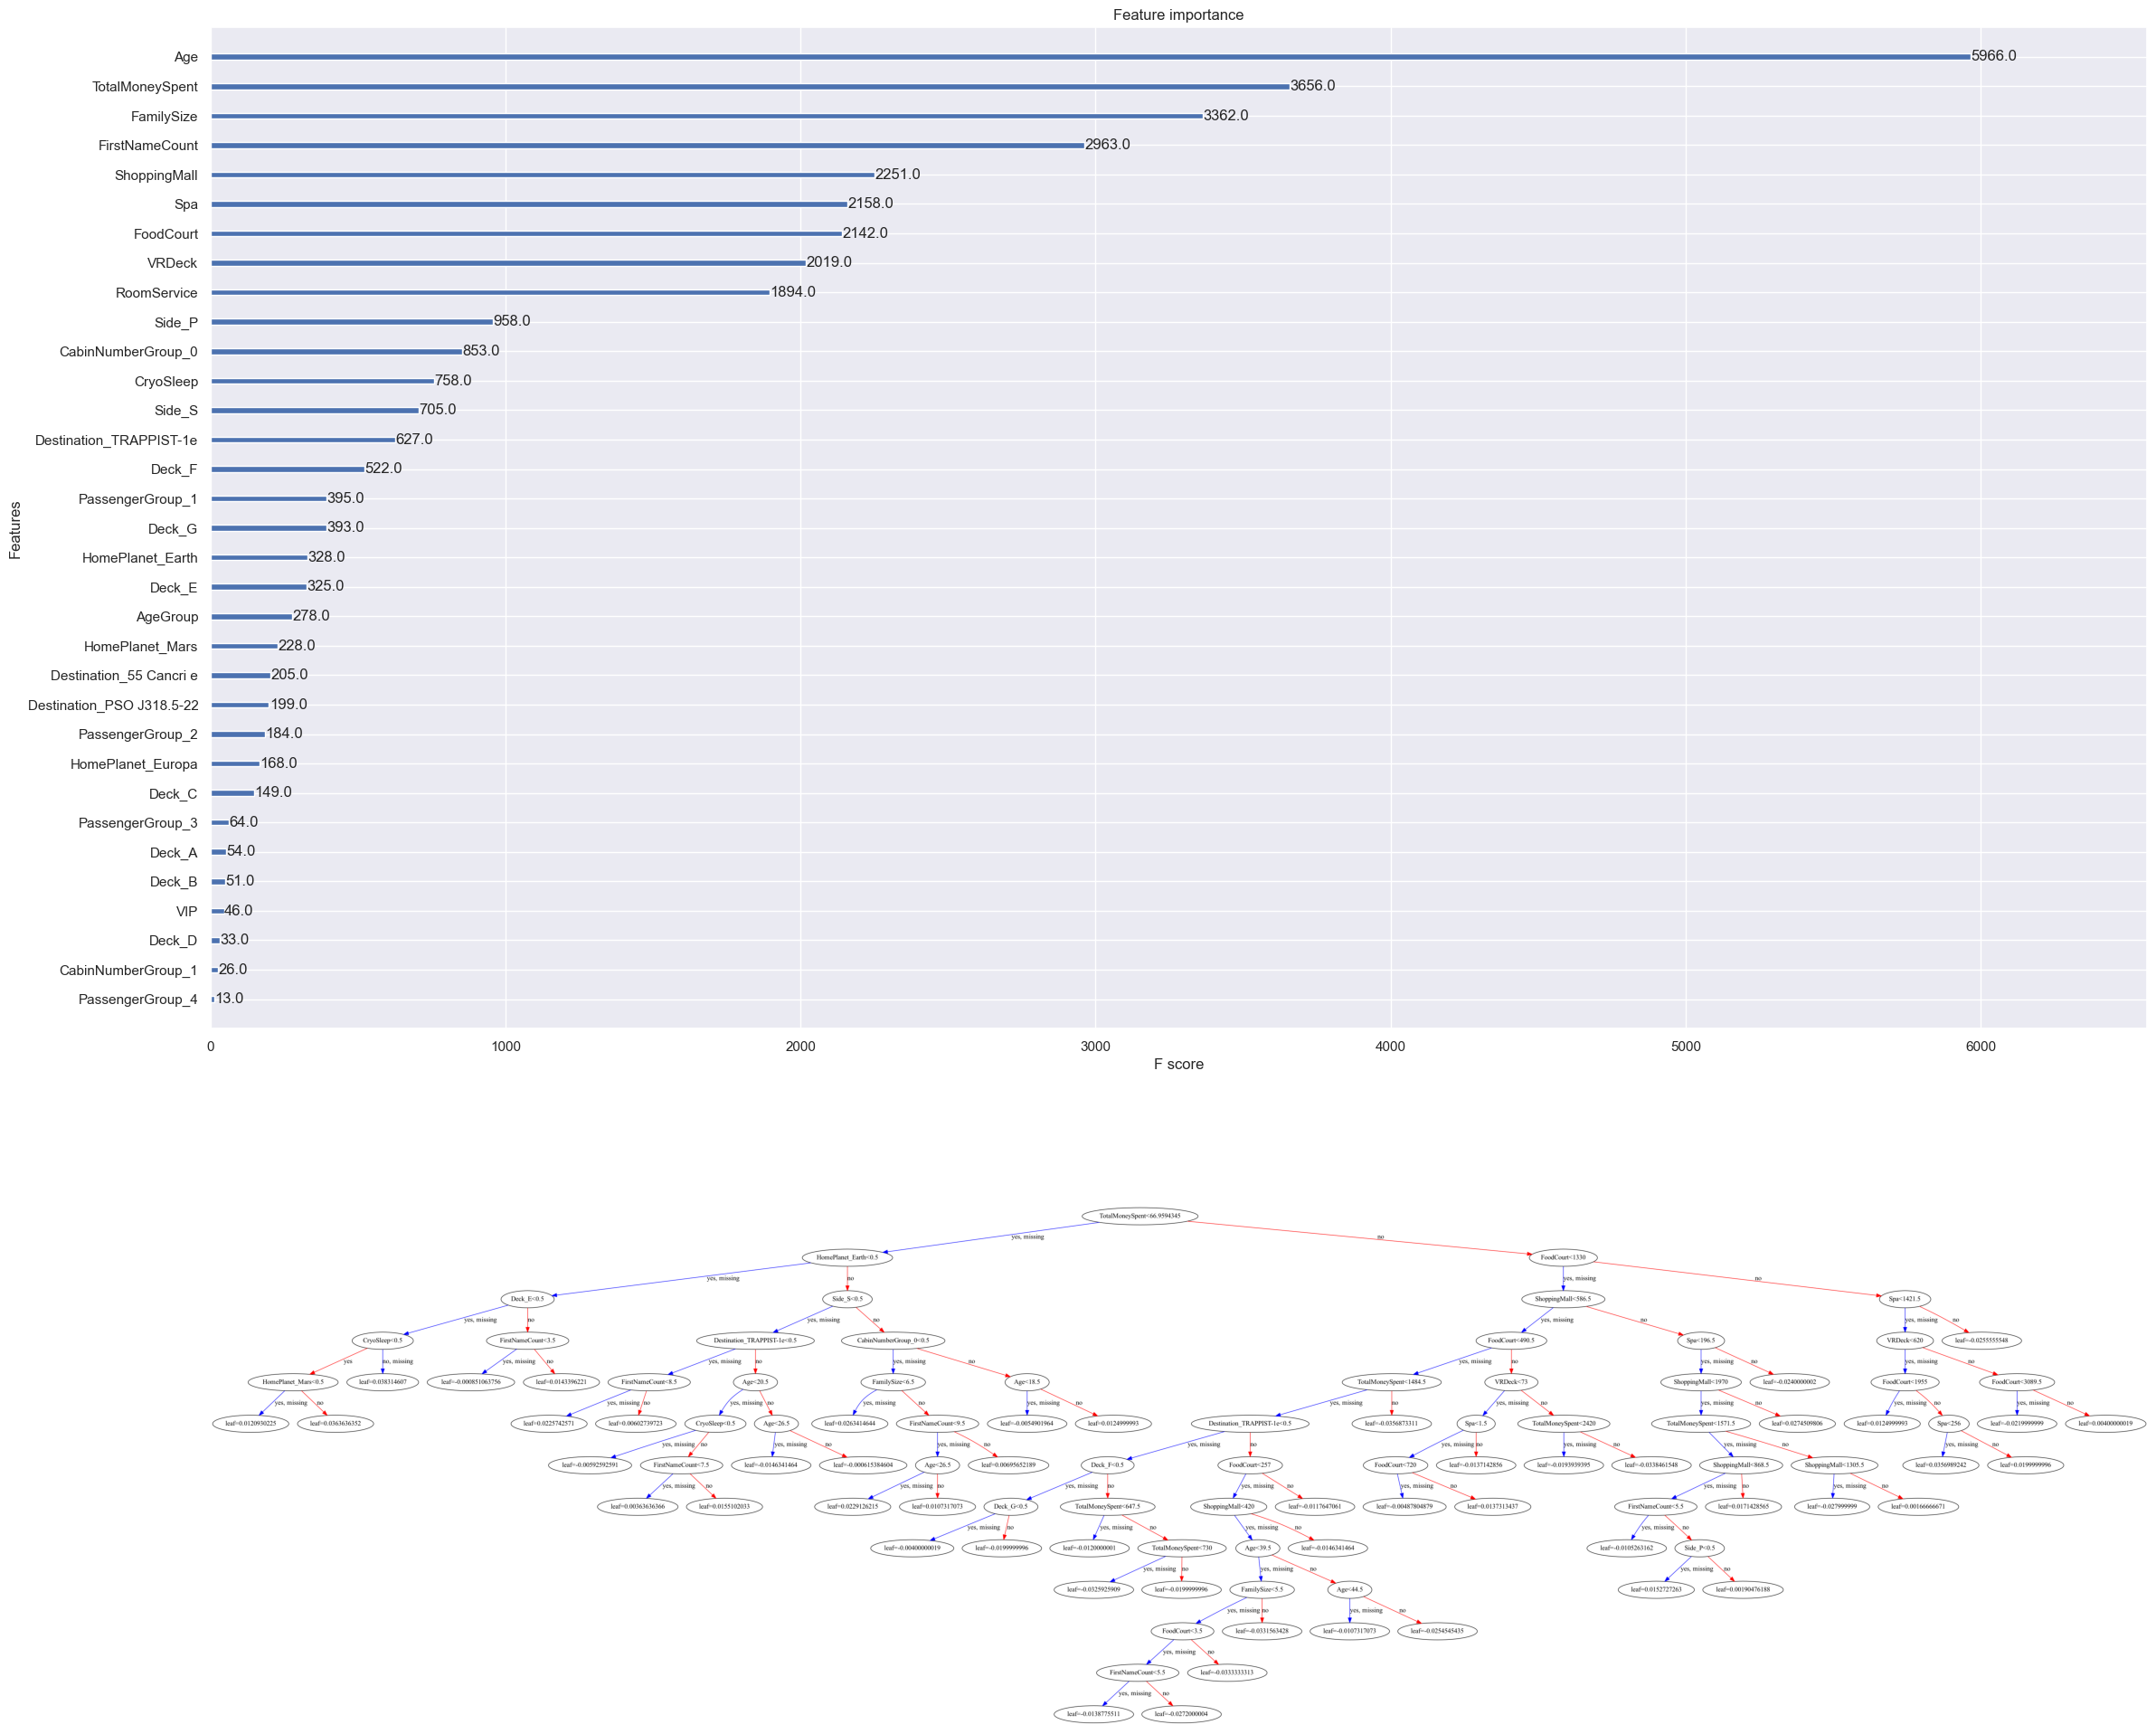

In [22]:
fix, ax = plt.subplots(2, 1, figsize=(24, 22))

plot_importance(best_xg_model, ax=ax[0])
plot_tree(best_xg_model, ax=ax[1])

plt.tight_layout()
plt.show()

In [24]:
test_data = all_data[all_data["Transported"].isna()]

y_predictions = best_xg_model.predict(test_data[ALL_FEATURES])
test_results = pd.concat([test_data["PassengerId"].reset_index(drop=True), pd.DataFrame(y_predictions, columns=["Transported"])], axis=1)
test_results["Transported"] = test_results["Transported"].astype(bool)
test_results.to_csv("submissionXGB.csv", index=False)

In [25]:
!kaggle competitions submit -c spaceship-titanic -f submissionXGB.csv -m "XGBoost model"

100%|██████████████████████████████████████| 56.4k/56.4k [00:01<00:00, 38.1kB/s]
Successfully submitted to Spaceship Titanic